# Final Step - Ensemble

Devin Austin and Duncan Tulimieri

In [1]:
# import libraries 
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16}) 
import seaborn as sns
import scipy.stats as stats
import warnings 
warnings.filterwarnings('ignore')
# personal classesß
import savingfigR as sf 
from ProcessData import ProcessForestData
from Models import pKNN, pLDA, pLogisticRegression, pQDA, pSVM

In [2]:
class SecureTheBag(ProcessForestData, pKNN, pLDA, pLogisticRegression, pQDA, pSVM):
    
    def __init__(self):
        # properties 
        self.plt_styles, self.bgs = ['seaborn-bright', 'dark_background'], ['_wbg', '_kbg']
        # method calls 
        self.X_train_scaled, self.X_test_scaled, self.y_train, self.y_test = self.load_data(perform_scale=True, sub_data_section='')
        self.X_train_unscaled, self.X_test_unscaled, _, _ = self.load_data(perform_scale=False, sub_data_section='')
        
        # Train models, predict score visualize 
        
        # KNN
        self.KNN_opt = self.train_KNN(self.X_train_unscaled, self.y_train, n_neighbors=pKNN.n_neighbors_best, weights=pKNN.weight_best)
        self.KNN_predictions = self.predict_KNN(self.KNN_opt, self.X_test_unscaled)
        self.KNN_score = self.score_KNN(self.KNN_opt, self.X_test_unscaled, self.y_test)
        self.plotConfusionMatrices(self.y_test, self.KNN_predictions, 'KNN')

        # LDA 
        self.LDA_opt = self.train_LDA(self.X_train_unscaled, self.y_train, solver=pLDA.solver_best)
        self.LDA_predictions = self.predict_LDA(self.LDA_opt, self.X_test_unscaled)
        self.LDA_score = self.score_LDA(self.LDA_opt, self.X_test_unscaled, self.y_test)
        self.plotConfusionMatrices(self.y_test, self.LDA_predictions, 'LDA')

        # LR
        self.LogisticRegression_opt = self.train_LogisticRegression(self.X_train_scaled, self.y_train, penalty=pLogisticRegression.penalty_best, C=pLogisticRegression.C_best, fit_B0=pLogisticRegression.intercept_best, l1_ratio=pLogisticRegression.l1_ratio_best)
        self.LogisticRegression_predictions = self.predict_LogisticRegression(self.LogisticRegression_opt, self.X_test_scaled)
        self.LogisticRegression_score = self.score_LogisticRegression(self.LogisticRegression_opt, self.X_test_scaled, self.y_test)
        self.plotConfusionMatrices(self.y_test, self.LogisticRegression_predictions, 'Logistic Regression')        
        
        # QDA
        self.QDA_opt = self.train_QDA(self.X_train_unscaled, self.y_train, reg_param=pQDA.reg_param_best)
        self.QDA_predictions = self.predict_QDA(self.QDA_opt, self.X_test_unscaled)
        self.QDA_score = self.score_QDA(self.QDA_opt, self.X_test_unscaled, self.y_test)
        self.plotConfusionMatrices(self.y_test, self.QDA_predictions, 'QDA')
        
        # SVM
        self.SVM_opt = self.train_SVM(self.X_train_scaled, self.y_train, C=pSVM.C_param_best, kernel=pSVM.kernel_best)
        self.SVM_predictions = self.predict_SVM(self.SVM_opt, self.X_test_scaled)
        self.SVM_score = self.score_SVM(self.SVM_opt, self.X_test_scaled, self.y_test)
        self.plotConfusionMatrices(self.y_test, self.SVM_predictions, 'SVM')
    
        
        # Ensemble
        self.all_model_predictions = np.vstack((self.KNN_predictions, self.LDA_predictions, self.LogisticRegression_predictions, self.QDA_predictions, self.SVM_predictions))
        self.ensemble_predictions = stats.mode(self.all_model_predictions, axis=0)[0]
        self.ensemble_score = np.sum(self.y_test == self.ensemble_predictions)/len(self.y_test)
        self.plotConfusionMatrices(self.y_test, self.ensemble_predictions, 'Ensemble')

        # Visualize 
        self.plotScoreBars(np.array([self.KNN_score, self.LDA_score, self.LogisticRegression_score, self.QDA_score, self.SVM_score, self.ensemble_score]), 
                            ['KNN', 'LDA', 'Logistic', 'QDA', 'SVM', 'Ensemble'])
        

    # Visualizations
    def plotScoreBars(self, scores, models):
        for bg, style in zip(self.bgs, self.plt_styles):
            plt.style.use('default')
            with plt.style.context(style):
                print(f'style = {style}, bg = {bg}')
                fig = plt.figure()
                ax = sns.barplot(x=models, y=scores*100, zorder=3)
                ax.bar_label(ax.containers[0], fmt='%.2f')
                plt.ylim([0, 110])
                plt.yticks(np.linspace(0,100,5))
                plt.grid()
                plt.xlabel('Model')
                plt.ylabel('Score (%)')
                plt.show()
                sf.best_save(fig, 'all_models_scores'+bg)

    def plotConfusionMatrices(self, y, yhat, model_name):
        # calculate confusion marix 
        uniqueY = np.unique(y)
        confusion = np.full((len(uniqueY), len(uniqueY)), np.nan)
        for i, y_vals1 in enumerate(uniqueY): # predicted
            for j, y_vals2 in enumerate(uniqueY): # actual
                if i == j:
                    confusion[i,j] = np.sum((y_vals1 == yhat) & (y == y_vals1)) / np.sum(y == y_vals1)
                else:
                    confusion[j,i] = np.sum((yhat == y_vals1) & (y == y_vals2)) / np.sum(y == y_vals2)

        # plot confusion matrix 
        for bg, style in zip(self.bgs, self.plt_styles):
            plt.style.use('default')
            with plt.style.context(style):
                print(f'style = {style}, bg = {bg}')
                fig = plt.figure(figsize=(8,6))
                sns.heatmap(confusion*100, xticklabels=ProcessForestData.classifier_undummy, yticklabels=ProcessForestData.classifier_undummy,vmin=0,vmax=100, cbar_kws={'label':'%'})
                plt.xlabel('Predicted')
                plt.ylabel('Actual')
                plt.title(model_name)
                plt.show()
                sf.best_save(fig, model_name+'_confusion'+bg)


style = seaborn-bright, bg = _wbg


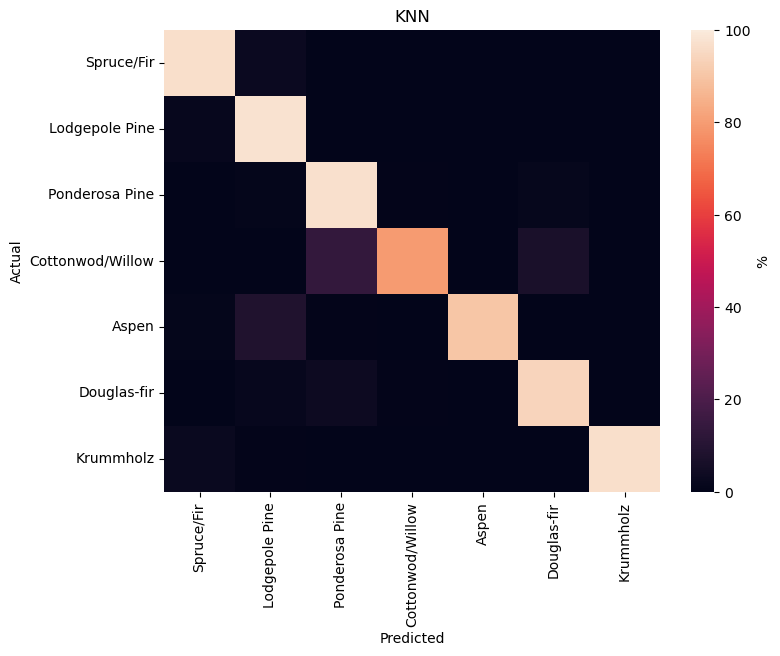

style = dark_background, bg = _kbg


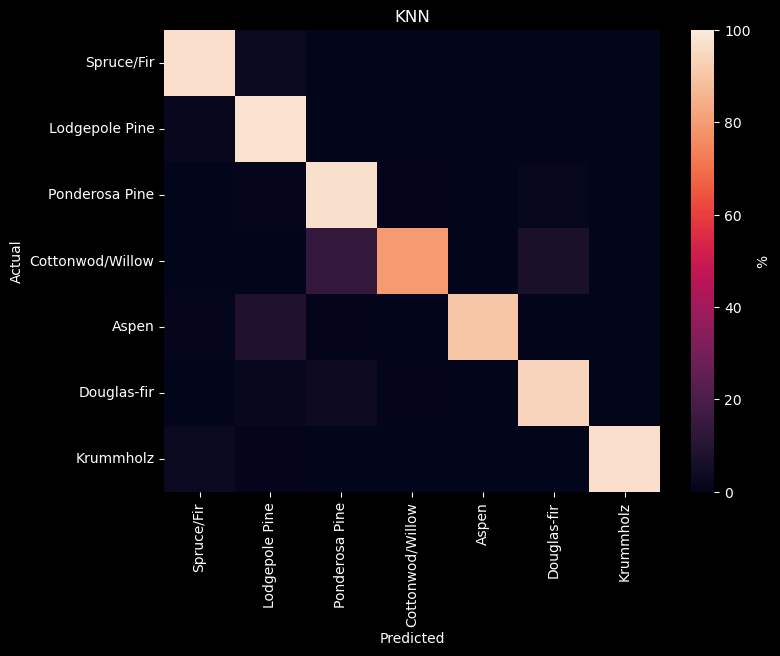

style = seaborn-bright, bg = _wbg


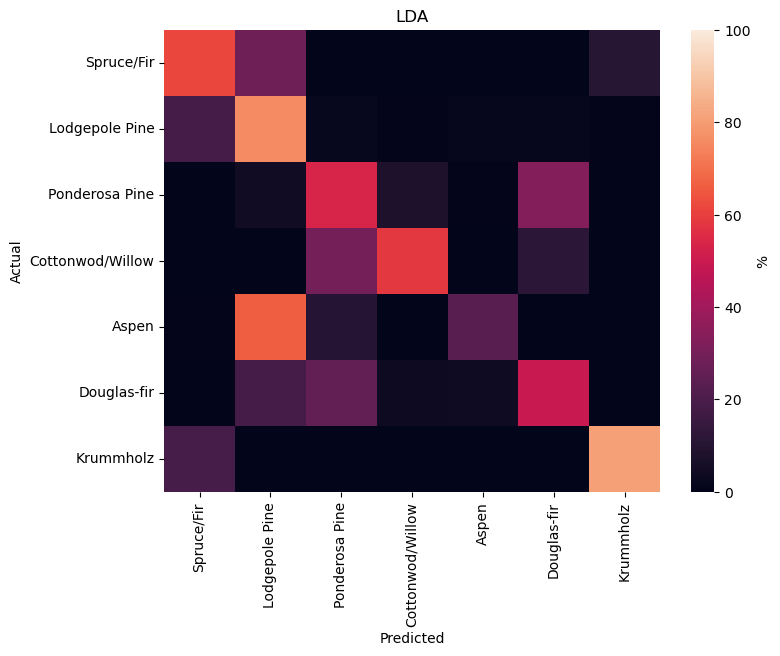

style = dark_background, bg = _kbg


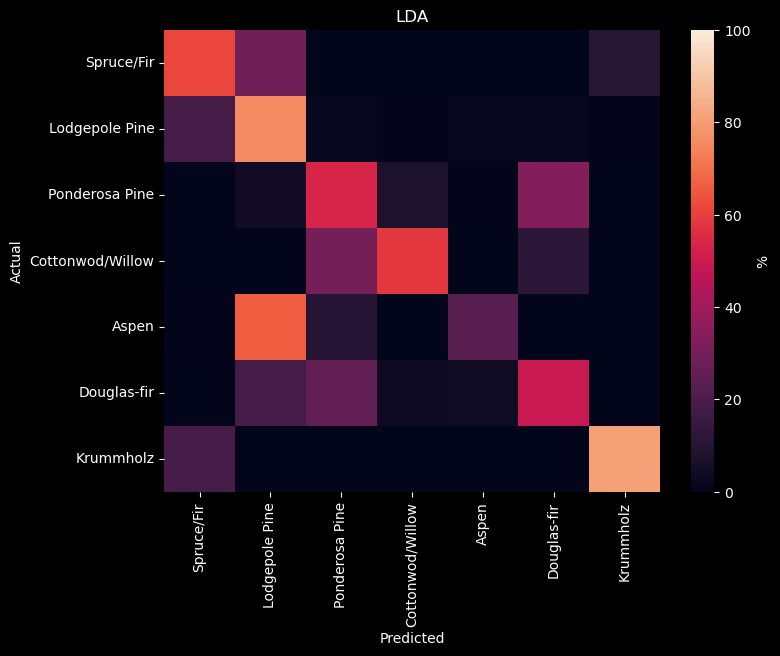

style = seaborn-bright, bg = _wbg


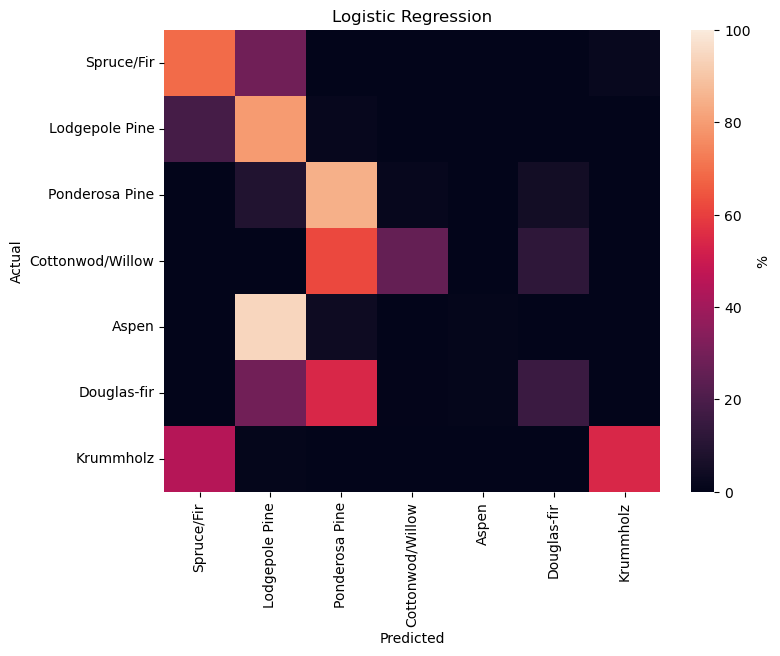

style = dark_background, bg = _kbg


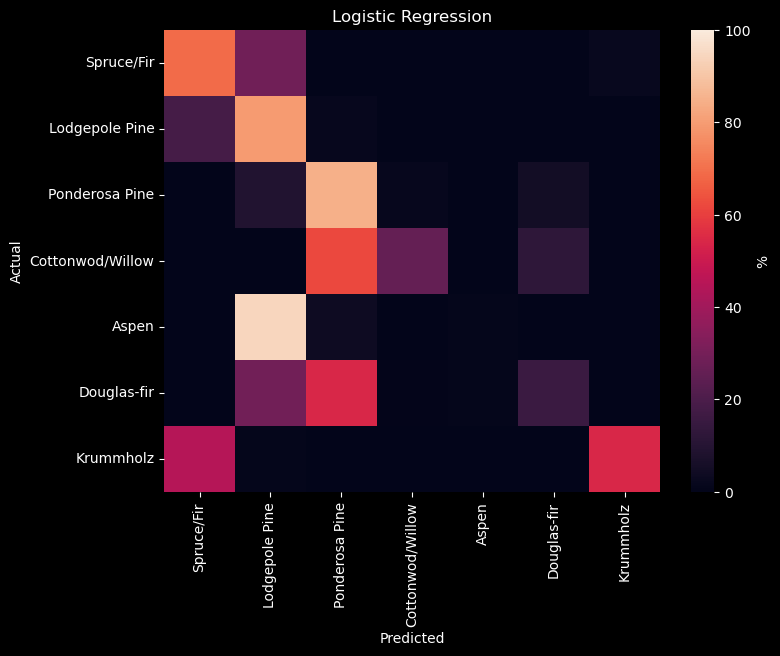

style = seaborn-bright, bg = _wbg


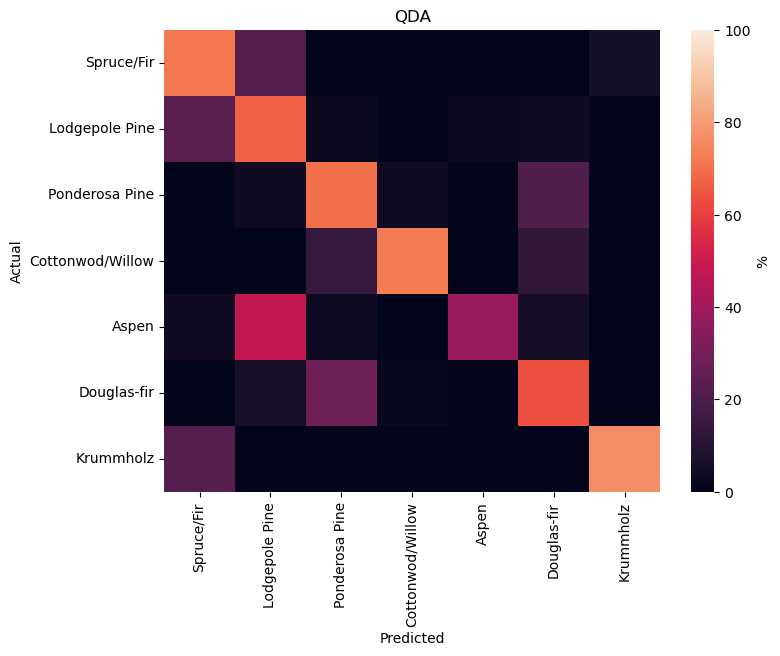

style = dark_background, bg = _kbg


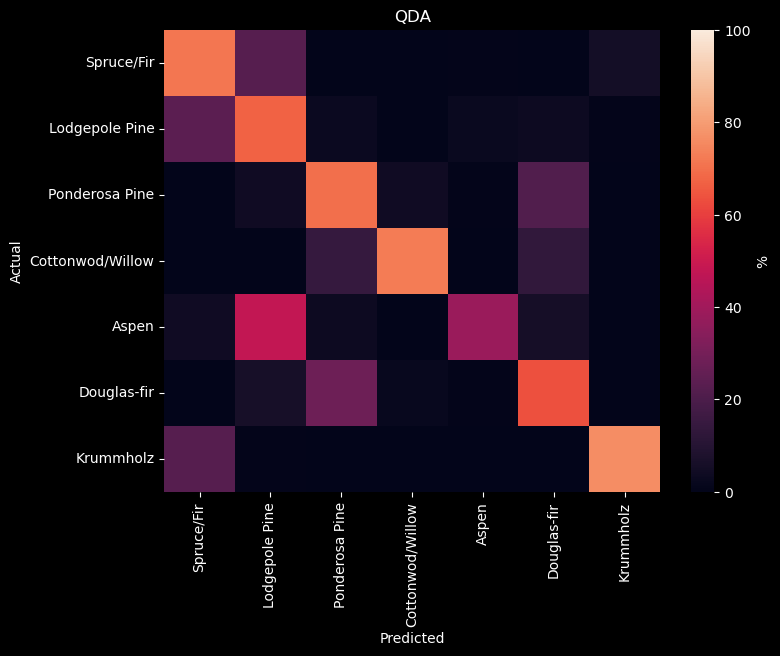

style = seaborn-bright, bg = _wbg


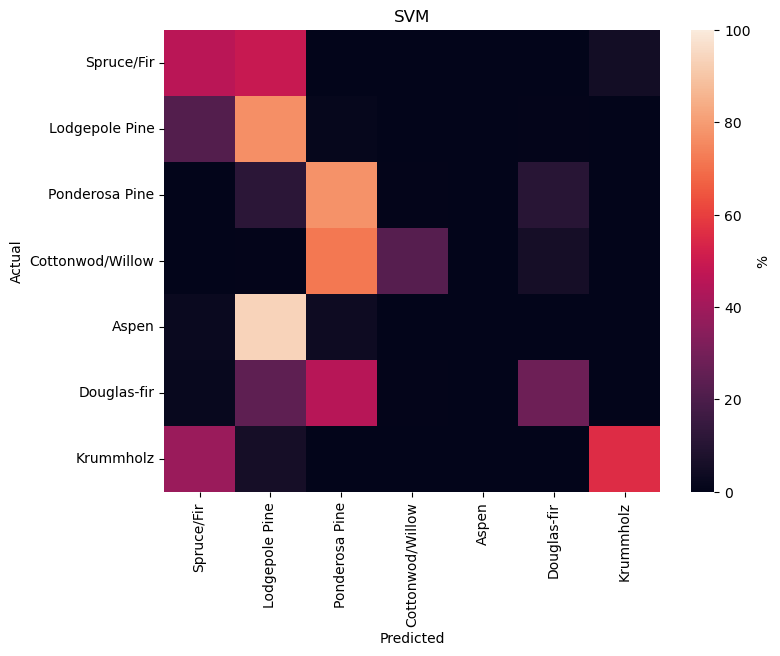

style = dark_background, bg = _kbg


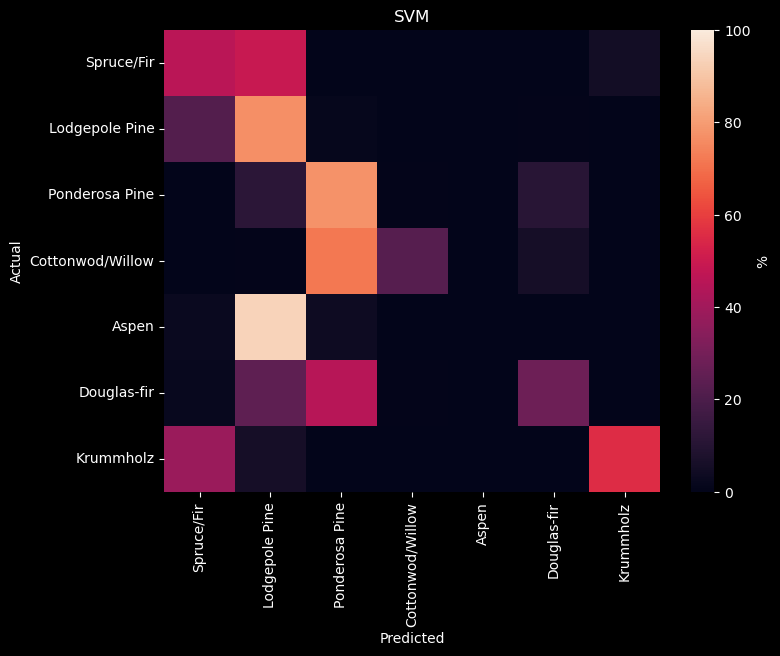

style = seaborn-bright, bg = _wbg


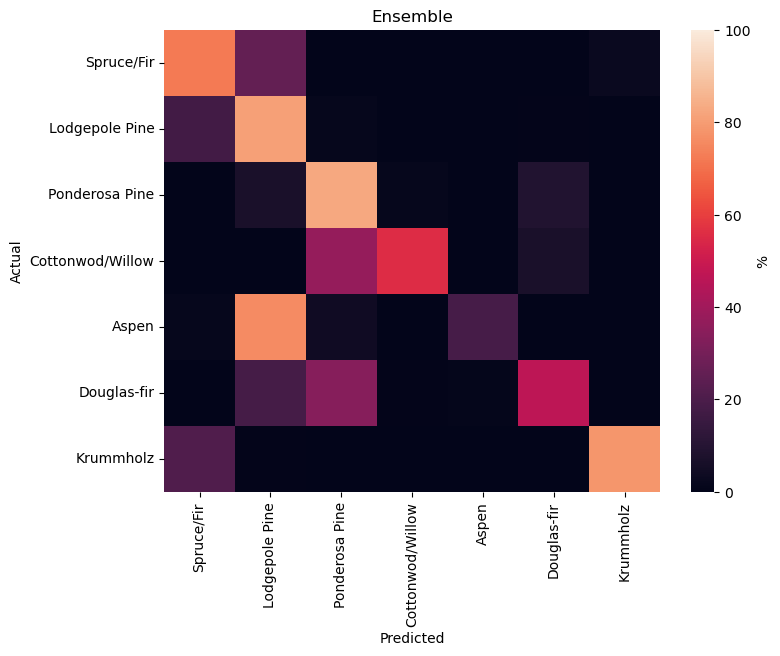

style = dark_background, bg = _kbg


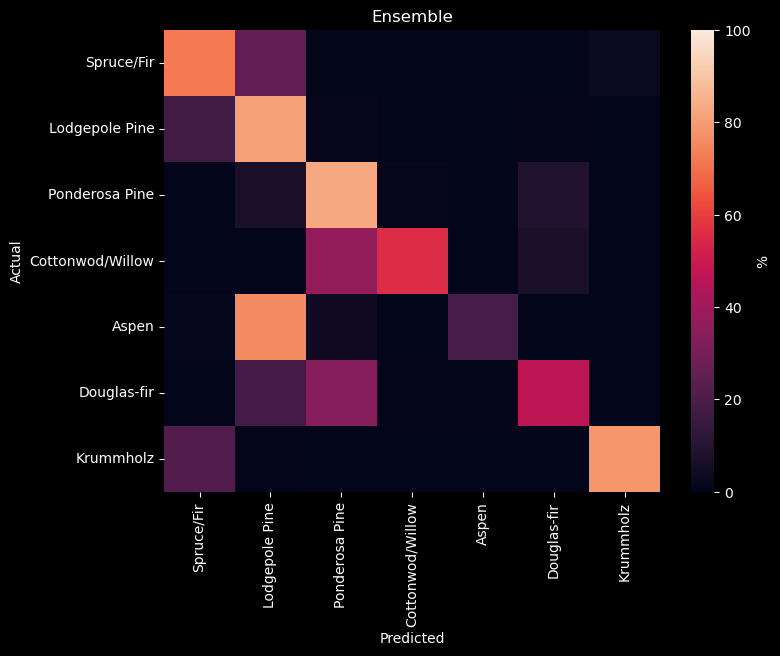

style = seaborn-bright, bg = _wbg


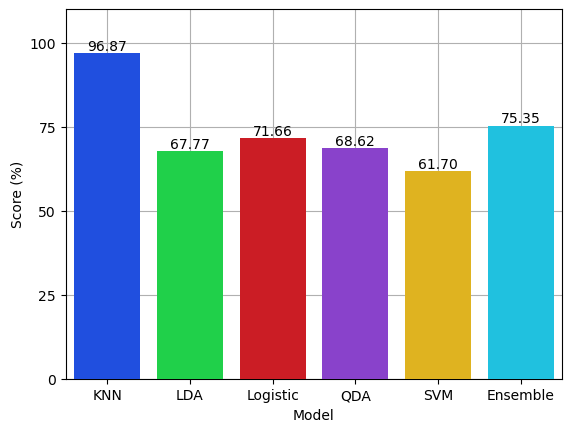

style = dark_background, bg = _kbg


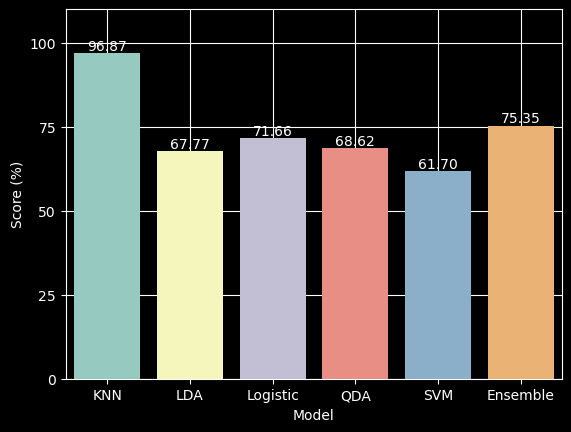

In [3]:
SecureTheBag()